In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from matplotlib import cm
from tqdm import tqdm
import seaborn as sns

In [3]:
def ecdf(data, missing):
	""" Compute ECDF  with missing data 
		
		Inputs
		------
		data : array of data
		missing : index of missing data
		
		Outputs
		-------
		empirical cumulative distribution function
	"""
	index = np.argsort(data)
	ecdf = np.zeros(len(index))
	for i in index:
		ecdf[i] = (1.0 / np.sum(missing)) * np.sum((data <= data[i]) * missing) # compute ecdf
		
        
	return ecdf
	
def dist(X, lmbd, missing):
	"""
		Compute matrix of F-Madogram (a une constante pres) using the empirical cumulative distribution function
		
		Inputs
		------
		X : a matrix composed of ecdf
		lmbd : a parameter between 0 and 1
		missing : vector indicate if we have the complete value

		Outputs
		-------
		A matrix with quantity equals to 0 if i=j (diagonal) and equals to sum_t=1^T |F(X_t)^{\lambda} - G(Y_t)^{1-\lambda}| if i \neq j
	"""
	ncols = X.shape[1]
	nrows = X.shape[0]
	col_index = np.where(missing == 1)
	X = X [:, col_index]
	dist = np.zeros([nrows, nrows])
	for i in range(0,nrows):
		for j in range(0,i):
			if i == j:
				dist[i,i] = 0
			else :
				F_x = np.squeeze(X[j,:])
				G_y = np.squeeze(X[i,:])
				d = np.linalg.norm(np.power(F_x,lmbd) - np.power(G_y,1-lmbd), ord = 1) - (lmbd) * np.sum(1-np.power(F_x,lmbd)) - (1-lmbd) * np.sum(1 - np.power(G_y, 1 - lmbd))
				dist[i,j] = d
				dist[j,i] = d
				
	return dist
	
def fmado(x, lmbd):
	"""
		This function
		
		Inputs
		------
		x : a matrix
		lmbd : constant between 0 and 1 use for the lambda F-madogram

		Outputs
		-------
		A matrix equals to 0 if i = j and equals to |F(X)^{\lambda} - G(Y)^{1-\lambda}|
	"""
	
	Nnb = x.shape[1] // 2 
	Tnb = x.shape[0]
	
	#--- Distance Matrix
	#--- F-Madogram
	V = np.zeros([Tnb, Nnb])
	for p in range(0, Nnb):
		x_vec = np.array(x[:,p]) # x
		miss = np.array(x[:, Nnb + p])
		Femp = ecdf(x_vec, miss)
		V[:,p] = Femp 
	# With Madogram
	cross_missing = np.squeeze(np.multiply(x[:,Nnb], x[:, Nnb + 1]))
	Fmado = dist(np.transpose(V),lmbd = lmbd, missing = cross_missing) / (2 * np.sum(cross_missing)) + (1/2) * ((1 - lmbd*(1-lmbd))/ ((2-lmbd)*(1+lmbd))) # np.sum(cross_missing)
	
	return Fmado , np.sum(cross_missing)

def simu(target):
	"""
		Perform multiple simulation of the estimation of FMadogram with an increasing length of sample

		Inputs
		------

		target : a list which contain the following parameters
				- niter = number of replication
				- simulation = law that generate the data
				- presence = array that indicate the probabilities of being present
				- n_sample = array of multiple lengths of sample

		Outputs
		-------
		Array containing niter * length(n_sample) estimators of the FMadogram

	"""
	output = []

	for k in range(target['niter']):
		probs = [] ; length = []
		FMado_store = np.zeros(len(target['n_sample']))
		obs_all = target['simulation'](mean, cov, np.max(target['n_sample']))
		I = np.transpose([ np.random.binomial(1, p, np.max(target['n_sample'])) for p in target['presence'] ])
		obs_all = np.concatenate([obs_all, I], axis = 1)
		for i in range(0, len(target['n_sample'])):
			obs = obs_all[:target['n_sample'][i]]
			FMado, l = fmado(obs, target['lambda'])
			FMado_store[i] = FMado[0,1] 
			probs.append(target['presence']) ; length.append(l)

		output_cbind = np.c_[FMado_store, target['n_sample'], np.arange(len(target['n_sample'])),length,probs]
		output.append(output_cbind)

	return output

def simu_proba(target):
	"""
		Perform multiple simulation of the FMadogram estimator with an increase of the probability of missing

		Inputs
		------

		target : a list which contain the following parameters
				- niter = number of replication
				- simulation = law that generate the data
				- presence = array that indicate the multiple probabilities of being present
				- n_sample = length of sample

		Outputs
		-------
		Array containing niter * length(presence) estimators of the FMadogram
	"""

	output = []
	for k in tqdm(range(target['niter'])):
		probs = []
		FMado_store = np.zeros(len(target['presence']))
		obs_all = target['simulation'](mean, cov, np.max(target['n_sample']))
		for i in range(0, len(target['presence'])):
			I = np.transpose([ np.random.binomial(1,p, np.max(target['n_sample'])) for p in target['presence'][i] ])
			obs = np.concatenate([obs_all, I], axis = 1)
			FMado = fmado(obs)
			FMado_store[i] = FMado[0,1]
			probs.append(target['presence'][i])
		output_cbind = np.c_[FMado_store, np.repeat(target['n_sample'], len(target['presence'])),np.arange(len(target['presence'])), probs]
		output.append(output_cbind)

	return output

In [4]:
target = {}
target['niter'] = 1000
target['simulation'] = np.random.multivariate_normal
target['presence'] = [0.5,0.5]
#target['n_sample'] = [100, 250, 500, 1000, 5000, 10000]
target['n_sample'] = [10000]
target['lambda'] = 0.5

mean = [0,0]
cov = [[1,0],[0,1]]
	
dataset = simu(target)
df_FMado = pd.DataFrame(np.concatenate(dataset))
df_FMado.columns = ['FMado', 'n', 'gp','length', 'prob_X', 'prob_Y']

In [7]:
df_FMado

,FMado,n,gp,length,prob_X,prob_Y,FMado_scaled
0,0.135241,10000.0,0.0,2544.0,0.5,0.5,0.184813
1,0.135480,10000.0,0.0,2524.0,0.5,0.5,0.208716
2,0.130768,10000.0,0.0,2546.0,0.5,0.5,-0.262446
3,0.135735,10000.0,0.0,2572.0,0.5,0.5,0.234243
4,0.134742,10000.0,0.0,2492.0,0.5,0.5,0.134934
...,...,...,...,...,...,...,...
995,0.135014,10000.0,0.0,2518.0,0.5,0.5,0.162098
996,0.135683,10000.0,0.0,2452.0,0.5,0.5,0.228988
997,0.129603,10000.0,0.0,2462.0,0.5,0.5,-0.378999
998,0.136762,10000.0,0.0,2543.0,0.5,0.5,0.336962


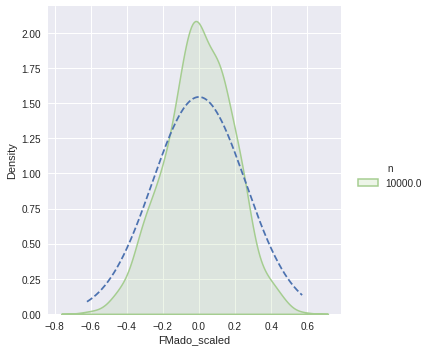

In [8]:
def var_mado_missing(x, p_xy, p_x, p_y):
  value = ((x ** 2 * (1-x)**2) / (1+x*(1-x))**2) * ( (p_xy**-1) / (1+2*x*(1-x)) - (p_x**-1)* (1-x) / (1+x+2*x*(1-x)) - (p_y**-1)*x / (2-x+2*x*(1-x)))
  return value

def gauss_function(x,x0, sigma):
    return np.sqrt(1/ (2*np.pi * sigma**2)) * np.exp(-(x - x0) ** 2 / (2 * sigma**2))

df_FMado['FMado_scaled'] = (df_FMado.FMado - df_FMado.groupby('n')['FMado'].transform('mean')) * np.sqrt(df_FMado.n)
mean = 0
sigma = np.sqrt(var_mado_missing(target['lambda'],(target['presence'][0])*(target['presence'][1]), target['presence'][0], target['presence'][1]))
x = np.linspace(min(df_FMado['FMado_scaled']), max(df_FMado['FMado_scaled']), 1000)
gauss = gauss_function(x,mean, sigma)

cmap = cm.get_cmap('OrRd')
sns.displot(data = df_FMado, x = "FMado_scaled", hue = "n", palette= "crest", kind = 'kde', common_norm = False, alpha = 0.2, fill = True, linewidth = 1.5)
plt.plot(x,gauss, linestyle = '--')
plt.show()

In [9]:
df_FMado['FMado_scaled'].var()

0.036003093217635715

In [10]:
sigma**2

0.06666666666666665

100%|██████████| 100/100 [00:04<00:00, 20.08it/s]


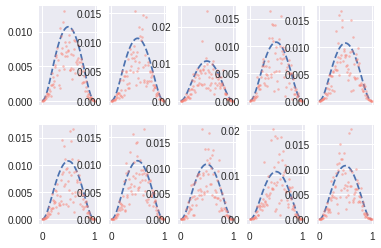

In [ ]:
%matplotlib inline
target = {}

target['niter'] = 10
target['simulation'] = np.random.multivariate_normal
target['presence'] = [0.1,0.1]
n_sample = [10,20,30,40,50,60,70,80,90,100]

mean = [0,0]
cov = [[1,0],[0,1]]

lmbds = np.linspace(0.0,1,100)
x = np.linspace(0, 1, 100)
values = var_mado_missing(x,(target['presence'][0])*(target['presence'][1]), target['presence'][0],target['presence'][1])  

fig, ax = plt.subplots(2,5, sharex = True)
ax = ax.ravel()
for i,n in enumerate(n_sample):
  target['n_sample'] = [n]
  var_lambda = []
  for lmbd in tqdm(lmbds):
    target['lambda'] = lmbd
    output = simu(target)
    df_FMado = pd.DataFrame(np.concatenate(output))
    df_FMado.columns = ['FMado', 'n', 'length','gp', 'prob_X', 'prob_Y']
    df_FMado['FMado_scaled'] = (df_FMado.FMado - df_FMado.groupby('n')['FMado'].transform('mean')) * np.sqrt(df_FMado.n)
    output = df_FMado['FMado_scaled'].var()
    var_lambda.append(output)
  ax[i].plot(x, values, '--')
  ax[i].plot(lmbds, var_lambda, '.', markersize = 5, alpha = 0.5, color = 'salmon')